# MIMICScn_SSP370
- Reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- **Switched to updated CLM5-GSWP3 inputs (created with ctsm_dev110 tag)**
  - Reduced HR biases in mid- and high lats
- Data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/*/OUTPUT_CN/SPIN

### Notable parameter changes
- Increased MIMICS leaching (function of total DIN pool) 
- Removed density dependent turnover, beta function from Emily's paper
- Introduces flexible microbial C:N, as a function of `fmet` to increase MIC C:N
- Increases FI from inputs to SOMc to increase C:N of total pools
- Decreases KO from 6 to 4, reduces SOMc stocks
- MIMICS and CASA simulation in CN mode and C only.
- **`MIMICS_mod5_GSWP3_KO4`** + `MIMICS_mod5_Conly_KO4`
- `CASACNP_mod4_GSWP3` + `CASACNP_mod4_Conly`
- `MIMICS_mod5_GSWP3_KO4_SOMp4a`, increase fraction of soilC in SOMp

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print('xarray version ' + xr.__version__)
%matplotlib inline

xarray version 0.16.1


In [2]:
path= '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/'
sim = ['MIMICS_mod5_GSWP3_KO4_SOMp4a', 
       'MIMICS_mod5_GSWP3_KO4',
       'MIMICS_mod5_Conly_KO4',
       'CASACNP_mod4_GSWP3', 
       'CASACNP_mod4_Conly']
fin = [path + i for i in sim]

CNtype = ['CN','CN','C','CN','C']
suffix = ['/OUTPUT_'+j+'/SSP370/' for j in CNtype]

fin = [i + j for i, j in zip(fin, suffix)]
file = ['ann_mimics_pool_flux_1901_2100.nc','ann_casaclm_pool_flux_1901_2100.nc']
nsim =len(sim)
print(sim)

['MIMICS_mod5_GSWP3_KO4_SOMp4a', 'MIMICS_mod5_GSWP3_KO4', 'MIMICS_mod5_Conly_KO4', 'CASACNP_mod4_GSWP3', 'CASACNP_mod4_Conly']


#### Open datasets and combine MIMICS output into one file

In [3]:
files_mim = [i + file[0] for i in fin[0:3]]
files_mim[0]

'/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_SOMp4a/OUTPUT_CN/SSP370/ann_mimics_pool_flux_1901_2100.nc'

In [4]:
files_mim = [i + file[0] for i in fin[0:3]]
sim_mim = ['MIMcn*', 'MIMcn', 'MIMc']
simdim_mim  = xr.DataArray(sim_mim, dims='sim', name='sim')
dims_mim    = [simdim_mim]
tmp_mim = xr.open_mfdataset(files_mim,combine='nested',concat_dim=dims_mim)
print('--- read in MIMICS data ---')

files_cas = [i + file[1] for i in fin]
sim_cas = ['MIMcn*', 'MIMcn', 'MIMc','CAScn','CASc']
simdim_cas  = xr.DataArray(sim_cas, dims='sim', name='sim')
dims_cas    = [simdim_cas]
tmp_cas = xr.open_mfdataset(files_cas,combine='nested',concat_dim=dims_cas)
print('--- read in CASA data ---')

--- read in MIMICS data ---
--- read in CASA data ---


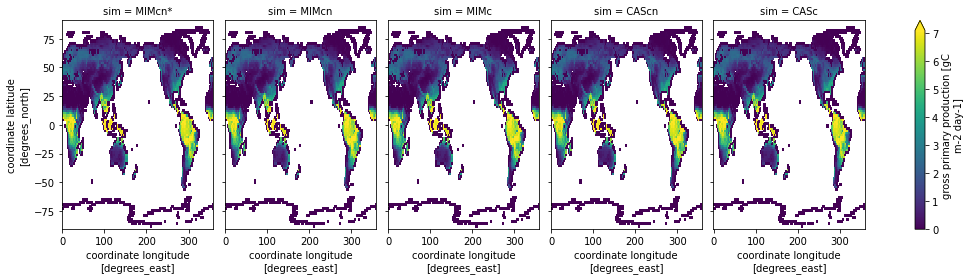

In [5]:
# still need to be careful for non-zero variables
tmp_cas.cgpp.isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;
#print(tmp_cas.var)

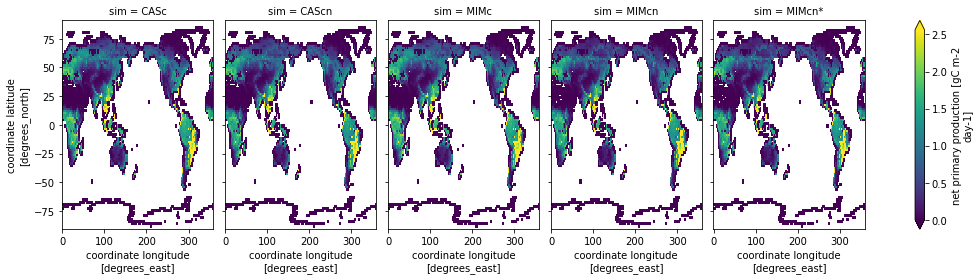

In [6]:
ds = xr.combine_by_coords([tmp_mim,tmp_cas],compat='override',combine_attrs='drop')
ds.cnpp.isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;

#### Sum soil C & N pools

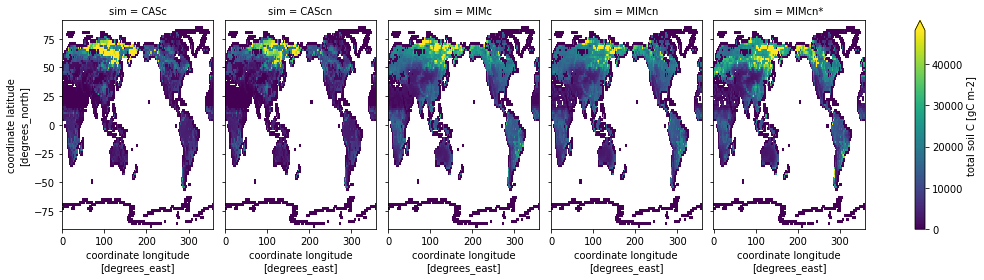

In [7]:
# unsure how to subset simulations to run utilities a different way...
# -- Xarray notes: We would love to be able to do indexing with labeled dimension names inside brackets, 
#    but unfortunately, Python does yet not support indexing with keyword arguments --
ds = ds.transpose('sim','lat','lon','time')
test0 = utils.sum_pools_combined(ds.isel(sim=0),'cas',CN='False')
test1 = utils.sum_pools_combined(ds.isel(sim=1),'cas',CN='True')
test2 = utils.sum_pools_combined(ds.isel(sim=2),'mim',CN='False')
test3 = utils.sum_pools_combined(ds.isel(sim=3),'mim',CN='True')
test4 = utils.sum_pools_combined(ds.isel(sim=4),'mim',CN='True')
ds= xr.concat([test0,test1,test2,test3,test4],'sim')
#ds2
ds.cTOT.isel(time=0).plot(x="lon", y="lat", col="sim", 
                          robust=True,figsize=[15,4],col_wrap=nsim)  ;

# lists to identify simulations later
CNsim = [1,3,4]  
MIMsim = [2,3,4]

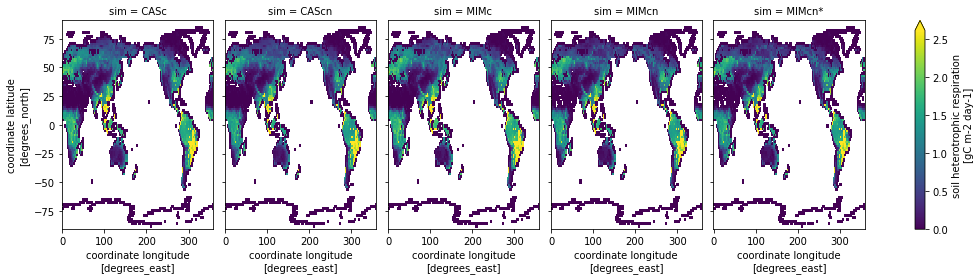

In [8]:
# check for correct fluxes (from utilities)
ds.cresp.isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;

#### Mask out low productivity grids (where NPP<10 gC/m2/y)
- Use mean of first 20 years from MIMICScn run to ensure same mask for all simulations

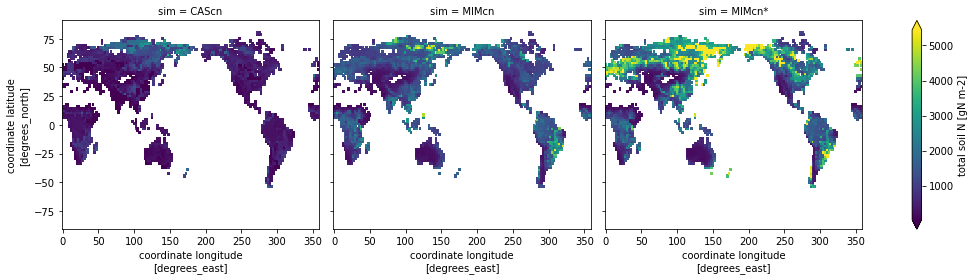

In [11]:
minNPP = 10/365 # npp given in gC/m2/d
initNPP = ds.cnpp.isel(sim=4,time=slice(0,20)).mean(dim='time')
#print(initNPP)                            
ds = ds.where(initNPP>minNPP)
ds.nTOT.isel(time=0, sim=CNsim).plot(
    x="lon", y="lat", col="sim", robust=True,figsize=[15,4],
    col_wrap=len(CNsim))  ;

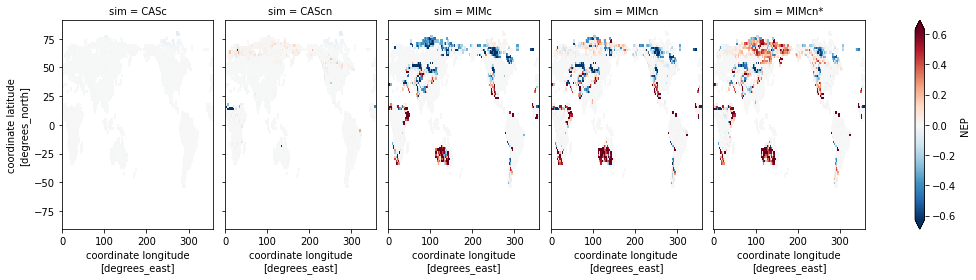

In [15]:
# QUICK LOOK AT MEAN NEP, 1901-1920, converted to gC/m2/y
(ds.NEP.isel(time=slice(0,20)).mean(dim='time')*365).plot(
    x="lon", y="lat", col="sim", robust=True,figsize=[15,4],
    col_wrap=nsim)  ;

mean MICc:SOMc 0.8686009


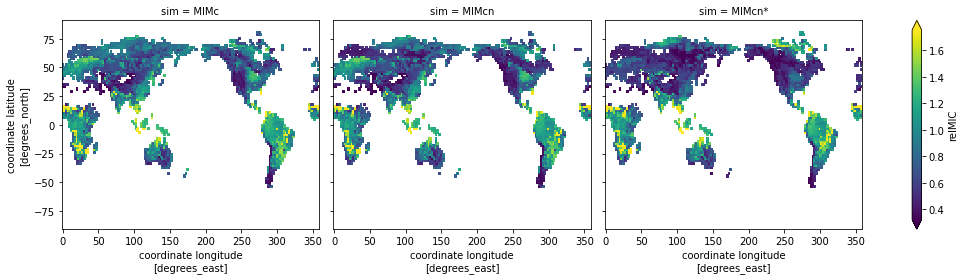

In [18]:
(ds.relMIC.isel(time=slice(0,20),sim=MIMsim).mean(dim='time')).plot(
     x="lon", y="lat", col="sim", robust=True,figsize=[15,4],
    col_wrap=len(MIMsim));
print('mean MICc:SOMc '+str(
    (ds.relMIC.isel(time=0)*ds.landarea/ds.landarea.sum()).sum().values))

Calculate zonal means

In [19]:
zon_mean = ds.mean(dim='lon') 

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

# Read observations:
- Microbial C and C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

In [20]:
obsIn = "/project/tss/wwieder/soilCN/global_run/"

xuMic = obsIn+'GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264/data/Global_Soil_Microbial_BiomassCN.nc'
dsXu = xr.open_mfdataset(xuMic, decode_times=True,combine='by_coords')
#dsXu.CN100cm.plot(robust=True);

GSDE = obsIn+'GSDE/'
GSDEoc = xr.open_mfdataset(GSDE+'OC5min.nc', decode_times=True,combine='by_coords')
GSDEtn = xr.open_mfdataset(GSDE+'TN5min.nc', decode_times=True,combine='by_coords')
GSDEoc['CN'] = GSDEoc.OC / GSDEtn.TN.where(GSDEtn.TN>0)
GSDEoc['CNmean'] = GSDEoc.CN.where(GSDEoc.depth<=100).mean(dim='depth')
print('max soil C:N '+str(GSDEoc['CNmean'].max().values))
#mask out silly values
GSDEoc['CNmean2'] = GSDEoc['CNmean'].where(GSDEoc['CNmean']<150)

HWSD = obsIn+'input_data/Soil_obs.nc'
dsOBS = xr.open_mfdataset(HWSD, decode_times=True,combine='by_coords')

NCSCD = obsIn+'input_data/NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsNCSCD = xr.open_mfdataset(NCSCD, decode_times=True,combine='by_coords')

dsHR = xr.open_mfdataset((obsIn+'RH_yr_Hashimoto2015.nc'), decode_times=False,combine='by_coords' )
#dims = time, lev, lat, lon gC/m2/y

dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
#dsOBS.HWSD_SOCall.plot();
zon_meanOBS = dsOBS.mean(dim='lon') * 1000 #gC/m2
zon_stdOBS = dsOBS.std(dim='lon') * 1000 #gC/m2
print('')
print('-- read in observed data -- ')
#dsNCSCD.NCSCD_SOC

max soil C:N 5353.0

-- read in observed data -- 


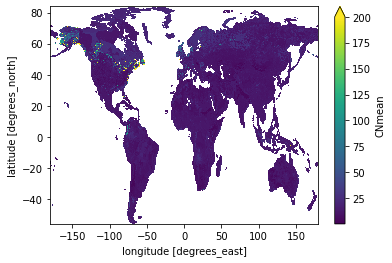

In [21]:
GSDEoc['CNmean'].plot(vmax=200);
#CNtemp = xr.concat([GSDEoc['CNmean'],GSDEoc['CNmean2']],'soilCN')
#print(CNtemp)
#simple = CNtemp.plot(col="soilCN", col_wrap=2,robust=True);

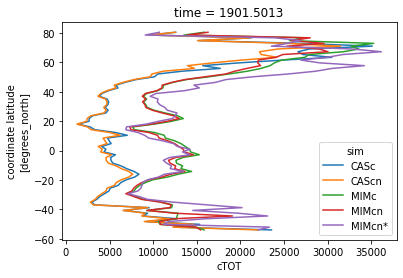

In [22]:
zon_mean.cTOT.isel(time=0).plot(hue='sim',y='lat') ;

In [23]:
#[simLabs[i] for i in [1,3,4]]+['Hashimoto']

### Plot zonal means for models and observations

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwiede

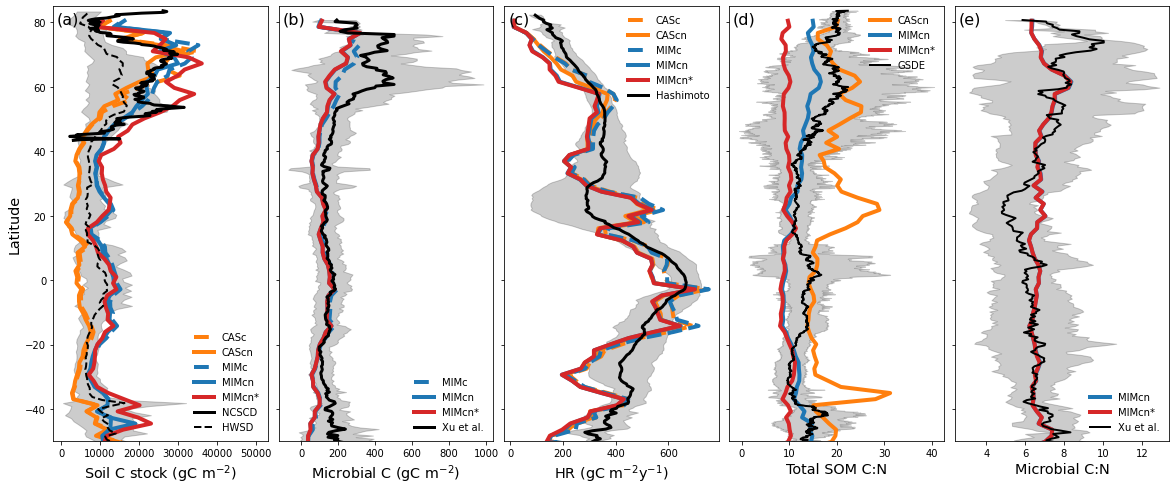

In [24]:
tPlot = 0  #time period to plot
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)

simLabs = ds['sim'].values.tolist()
color = ['tab:orange','tab:orange','tab:blue','tab:blue','tab:red'] 
linestyle= ['--', '-','--', '-', '-']                        

# SOC
v = 'cTOT'
labels = simLabs+['NCSCD','HWSD']
for i in range(nsim):
    ax1.plot(zon_mean.get(v).isel(time=tPlot,sim=i), 
             zon_mean.lat,lw=4,color=color[i],linestyle=linestyle[i])
ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax1.fill_betweenx(zon_meanOBS.lat,
                  zon_meanOBS.get('HWSD_SOCall') + zon_stdOBS.get('HWSD_SOCall'), 
                  zon_meanOBS.get('HWSD_SOCall') - zon_stdOBS.get('HWSD_SOCall'),
                  alpha=0.2, color='k')

ax1.set_xlabel('Soil C stock (gC $\mathregular{m^{-2}}$)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=4)
ax1.set_ylim(-50, 85)

# MICc
v = 'cMICtot' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = simLabs[2:5]+['Xu et al.']
for i in range(2,5):
    ax2.plot(zon_mean.get(v).isel(time=tPlot,sim=i), 
             zon_mean.lat,lw=4,color=color[i],linestyle=linestyle[i])
ax2.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=3, color='k')
ax2.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.SMC100cm.mean(dim='lon') + dsXu.SMC100cm.std(dim='lon'), 
                  dsXu.SMC100cm.mean(dim='lon') - dsXu.SMC100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax2.set_xlabel('Microbial C (gC $\mathregular{m^{-2}}$)', fontsize='x-large');
ax2.legend(labels=labels,frameon = False, fontsize='medium',loc=4)

# HR
v = 'cresp' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = simLabs+['Hashimoto']
for i in range(len(simLabs)):
    # fluxes gC/m2/d
    ax3.plot(zon_mean.get(v).isel(time=tPlot,sim=i)*365,    
             zon_mean.lat,lw=4,color=color[i],linestyle=linestyle[i])
ax3.plot(dsHR.co2.isel(time=-1,lev=0).mean(dim='lon'), dsHR.lat,lw=3, color='k')
ax3.fill_betweenx(dsHR.lat,   #add SD by lat
                  dsHR.co2.isel(time=-1,lev=0).mean(dim='lon') + dsHR.co2.isel(time=-1,lev=0).std(dim='lon'), 
                  dsHR.co2.isel(time=-1,lev=0).mean(dim='lon') - dsHR.co2.isel(time=-1,lev=0).std(dim='lon'),
                  alpha=0.2, color='k')
ax3.set_xlabel('HR (gC $\mathregular{m^{-2 } y^{-1}}$)', fontsize='x-large')
ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=1)

# Soil C:N
v = 'cnTOT' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = [simLabs[i] for i in CNsim]+['GSDE']
for i in CNsim:
    # fluxes gC/m2/d
    ax4.plot(zon_mean.get(v).isel(time=tPlot,sim=i),   
             zon_mean.lat,lw=4,color=color[i],linestyle=linestyle[i])
ax4.plot(GSDEoc['CNmean2'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
#ax4.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='r')
ax4.fill_betweenx(GSDEoc.lat,   #add SD by lat
                  GSDEoc['CNmean2'].mean(dim='lon') + GSDEoc['CNmean2'].std(dim='lon'), 
                  GSDEoc['CNmean2'].mean(dim='lon') - GSDEoc['CNmean2'].std(dim='lon'),
                  alpha=0.2, color='k')
ax4.set_xlabel('Total SOM C:N', fontsize='x-large');
ax4.legend(labels=labels, frameon = False, fontsize='medium',loc=0)

# MIC C:N
v = 'cnMIC' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = [simLabs[i] for i in [3,4]]+['Xu et al.']
for i in [3,4]:
    # fluxes gC/m2/d
    ax5.plot(zon_mean.get(v).isel(time=tPlot,sim=i),   
             zon_mean.lat,lw=4,color=color[i],linestyle=linestyle[i])
ax5.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax5.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.CN100cm.mean(dim='lon') + dsXu.CN100cm.std(dim='lon'), 
                  dsXu.CN100cm.mean(dim='lon') - dsXu.CN100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax5.set_xlabel('Microbial C:N', fontsize='x-large');
ax5.legend(labels=labels, frameon = False, fontsize='medium',loc=0);

# add panel labels
ax1.annotate(panel[0], xy=(0.07, 0.97), xycoords=ax1.transAxes, ha='center', va='center',fontsize=16)    
ax2.annotate(panel[1], xy=(0.07, 0.97), xycoords=ax2.transAxes, ha='center', va='center',fontsize=16)    
ax3.annotate(panel[2], xy=(0.07, 0.97), xycoords=ax3.transAxes, ha='center', va='center',fontsize=16)    
ax4.annotate(panel[3], xy=(0.07, 0.97), xycoords=ax4.transAxes, ha='center', va='center',fontsize=16)    
ax5.annotate(panel[4], xy=(0.07, 0.97), xycoords=ax5.transAxes, ha='center', va='center',fontsize=16);    

#plt.savefig(path+MIMsimCN+'/figs/'+MIMsimCN_p+'_Fig_1_ZonalSOM.pdf')


**Figure 1.** Zonal mean plots for MIMICS and CASA simulations (blue and orange lines, respectively) with coupled CN biogeochemistry and C-only configuration (solid and dashed lines, respectively) and relevant observations, (black lines with grey shading showing +/- 1 sigma of mean). Panels show (a) initial soil C stocks (gC m-2, 0-100 cm depth), (b) soil microbial biomass C stocks (gC m-2, 0-100 cm depth), (c) soil heterotrophic respiration fluxes (gC m-2 y-1),  (d) soil organic matter C:N ratio, and (e) microbial biomass C:N ratios.  See text for references of observations used in this analysis.

- Models show good agreement of stocks & fluxes 
- MIMICS-cn shows weak latitudal variation in soil and microbial C:N. CASA captures is because it uses a pft defined soil C:N

## Code below to write out table of global means?
- Table 1: Initial stocks & fluxes (1901-1920 means)
- Table 2: Change in global stocks and fluxes (mean 2000-2014)
GPP, NPP, HR, Soil C, microbial biomass, MIC:SOM, SOM C:N, microbial C:N

In [25]:
def globalSum ( varIn, area=ds.landarea.isel(sim=4) *1e6, timeC=1, conversion=1e-15, 
               units=None, pt=False):
    "Global weighted sum of fluxes & states"
    temp = varIn * area 
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

def globalMean ( varIn, area=ds.landarea.isel(sim=4) *1e6, timeC=1, conversion=1, 
                units=None, pt=False):
    "Global weighted mean"
    temp = varIn * area / area.sum()
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

d2y = 365
#MIMcnANN['cgpp'].isel(time=slice(0,20)).mean('time')
print(np.round(globalSum(ds['cnpp'].isel(time=slice(0,20)).mean('time'),
                         timeC=d2y, pt=False),1).values)

[42.  38.9 42.  37.6 37.5]


### Table of global means & change over time

In [29]:
row_names = ['cgpp','cnpp','cresp','cTOT',
             'cMICtot','relMIC','nNetMineralization',
             'cnTOT','cnMIC']
col_names = simLabs
nrow = len(row_names)
ncol = len(col_names)
init_table = np.empty((nrow,ncol))
fin_table = np.empty((nrow,ncol))

for i in range(ncol):
    for j in range(nrow):
        din = ds.isel(sim=i,time=slice(0,20)).mean('time') 
        din2 = ds.isel(sim=i,time=slice(-20,None)).mean('time') 
        #convert fluxes appropriately
        if j <=2:
            init_table[j,i] = np.round(globalSum(
                din[row_names[j]],timeC=d2y, pt=False),1).values
            fin_table[j,i] = np.round(globalSum(
                din2[row_names[j]],timeC=d2y, pt=False),1).values 
        # soil C stocks
        if j == 3:
            init_table[j,i] = np.round(globalSum(
                din[row_names[j]],pt=False),0).values
            fin_table[j,i] = np.round(globalSum(
                din2[row_names[j]],pt=False),0).values
        # MIC C stocks, Pg C
        if j == 4 :
            init_table[j,i] = np.round(globalSum(
                din[row_names[j]],pt=False),1).values
            fin_table[j,i] = np.round(globalSum(
                din2[row_names[j]],pt=False),1).values
        if j == 5 :
            init_table[j,i] = np.round(globalMean(
                din[row_names[j]],pt=False),3).values
            fin_table[j,i] = np.round(globalMean(
                din2[row_names[j]],pt=False),3).values

        # net Mineraliztion, Tg N / year
        if j == 6 :
            init_table[j,i] = np.round(globalSum(
                din[row_names[j]],timeC=d2y, conversion=1e-12, pt=False),0).values
            fin_table[j,i] = np.round(globalSum(
                din2[row_names[j]],timeC=d2y, conversion=1e-12, pt=False),0).values

        # soil C:N
        if j == 7 :
            init_table[j,i] = np.round(globalMean(
                din[row_names[j]],pt=False),1).values
            fin_table[j,i] = np.round(globalMean(
                din2[row_names[j]],pt=False),1).values

        # MIC C:N
        if j == 8 :
            init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),1).values
            fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),1).values

change_table = fin_table - init_table
percent_table = 100* fin_table / init_table - 100
print('initial state')
print(pd.DataFrame(init_table,  index=row_names, columns=col_names))
print('  --  ')
print('Change by '+str(ds.time.isel(time=-1).values) )
print(pd.DataFrame(change_table,  index=row_names, columns=col_names))
pd.DataFrame(percent_table,  index=row_names, columns=col_names)

initial state
                     CASc  CAScn      MIMc     MIMcn    MIMcn*
cgpp                106.1  106.1   106.100   106.100   106.100
cnpp                 42.0   38.9    42.000    37.600    37.500
cresp                42.0   38.9    42.000    37.600    37.500
cTOT                997.0  885.0  1582.000  1493.000  1761.000
cMICtot               0.0    0.0    14.800    13.100    13.100
relMIC                0.0    0.0     0.925     0.877     0.836
nNetMineralization    0.0  887.0     0.000   857.000   857.000
cnTOT                 0.0   18.9     0.000    11.900     9.400
cnMIC                 0.0    0.0     0.000     6.800     6.800
  --  
Change by 2100.5015
                    CASc  CAScn     MIMc    MIMcn   MIMcn*
cgpp                51.5   51.5   51.500   51.500   51.500
cnpp                14.0   12.3   14.000   13.200   12.500
cresp               14.2   12.7   15.900   14.700   13.600
cTOT                -1.0   -4.0 -137.000 -105.000  -50.000
cMICtot              0.0    0.0   

,CASc,CAScn,MIMc,MIMcn,MIMcn*
cgpp,48.539114,48.539114,48.539114,48.539114,48.539114
cnpp,33.333333,31.619537,33.333333,35.106383,33.333333
cresp,33.809524,32.647815,37.857143,39.095745,36.266667
cTOT,-0.100301,-0.451977,-8.659924,-7.032820,-2.839296
cMICtot,NaN,NaN,19.594595,22.137405,16.793893
relMIC,NaN,NaN,29.405405,30.216648,23.325359
nNetMineralization,NaN,36.865840,NaN,43.290548,49.124854
cnTOT,NaN,-0.529101,NaN,-4.201681,-1.063830
cnMIC,NaN,NaN,NaN,0.000000,0.000000


In [30]:
pd.DataFrame(init_table,  index=row_names, columns=col_names).to_excel("ssp370_Table1.xlsx")  
pd.DataFrame(change_table,  index=row_names, columns=col_names).to_excel("ssp370_Table2.xlsx")  

### Look at changes over historical period

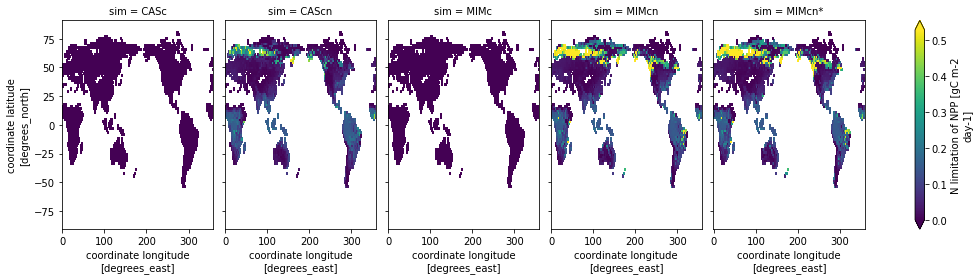

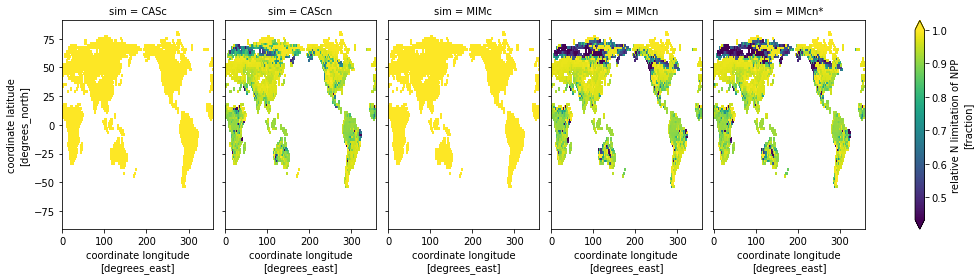

In [32]:
ds['Nlimit'] = ds['cnpp'].isel(sim=0) - ds['cnpp']
ds['Nlimit'].attrs['long_name'] = 'N limitation of NPP'
ds['Nlimit'].attrs['units'] = ds['cnpp'].attrs['units']
ds['Nlimit'].isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=5)

ds['relNlimit'] = ds['cnpp']/ ds['cnpp'].isel(sim=0)
ds['relNlimit'].attrs['long_name'] = 'relative N limitation of NPP'
ds['relNlimit'].attrs['units'] = 'fraction'
ds['relNlimit'].isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=5); 

## Plot global time series

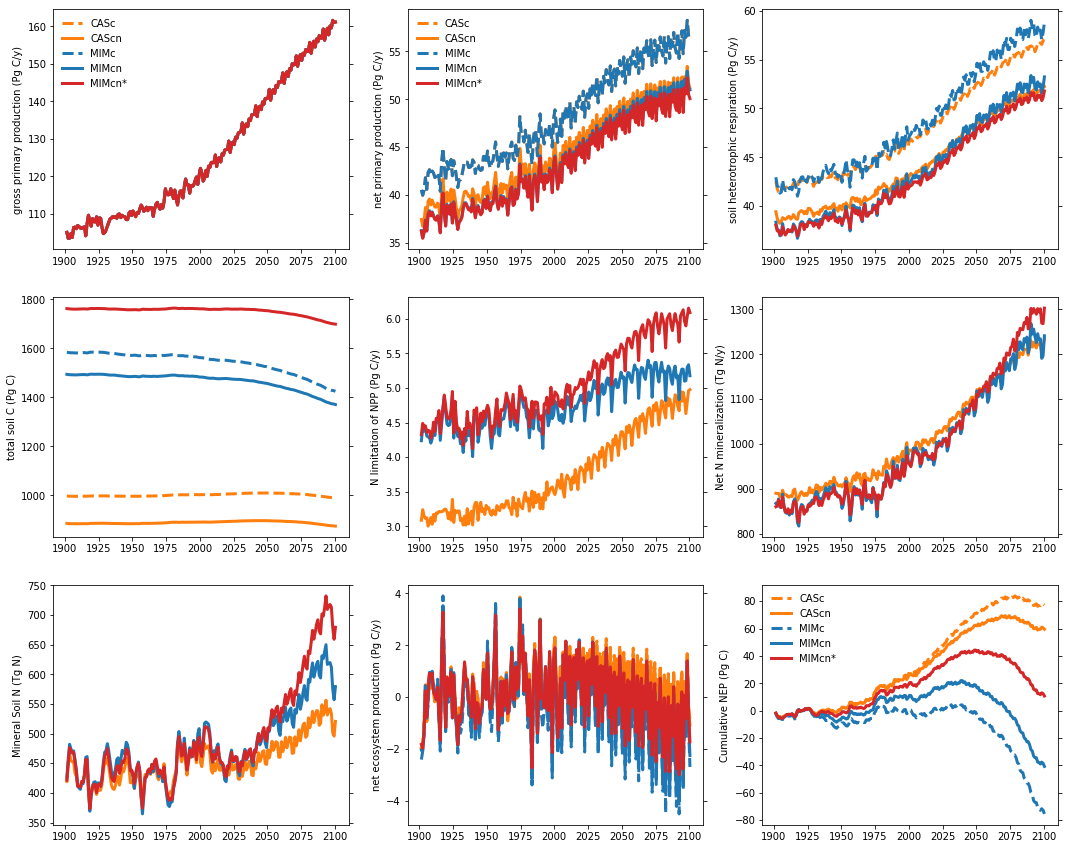

In [33]:
model = simLabs
var = ['cgpp','cnpp','cresp','cTOT','Nlimit',
       'nNetMineralization','nMineral','NEP']
nvar  = len(var)
timeC = [365,365,365,1,365,
         365,1,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15,
              1e-12,1e-12,1e-15]
units = ['(Pg C/y)','(Pg C/y)','(Pg C/y)','(Pg C)','(Pg C/y)',
         '(Tg N/y)','(Tg N)','(Pg C/y)']

fig = plt.figure(figsize=[18,15])
        
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel(ds[var[i]].attrs['long_name']+' '+units[i])
    for j in range(len(model)):
        temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## zero out N fluxes for C-only runs
        if j == 2 or j == 0:
            if i == 4 or i == 5 or i == 6:
                temp = temp*np.nan
        ax.plot(ds.time, temp, lw=3,color=color[j],linestyle=linestyle[j])        
    if i<2:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax = fig.add_subplot(3, 3, 9)
i = 7  
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
for j in range(len(model)):
    ax.plot(ds.time, np.cumsum(globalSum(ds[var[i]].isel(sim=j),
                               timeC=timeC[i],conversion=conversion[i])), 
            lw=3,color=color[j],linestyle=linestyle[j])        
ax.legend(labels=model, frameon = False, fontsize='medium');

**Figure X** trends in ecosystem C & N fluxes and pools over the historical period simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Both N models have a higher cumulative NEP, but changes w/ MIMICS-CN are greater.
- Implies longer MRT of soil C pools in CN models, relative to their C-only counterparts 
- **OR** larger increases in NPP from regions experiencing N limitation (relative to the C only model). 
- From change time series below, seems like the biggest differences are in HR (not NPP)

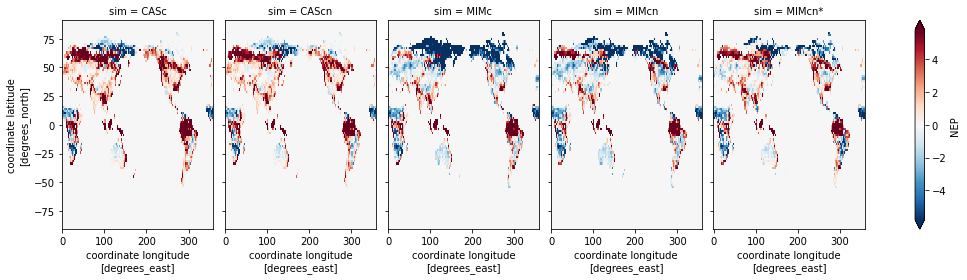

In [34]:
cumNEP = ds['NEP'].cumsum(dim='time').isel(time=-1)
cumNEP.plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],
            col_wrap=nsim);

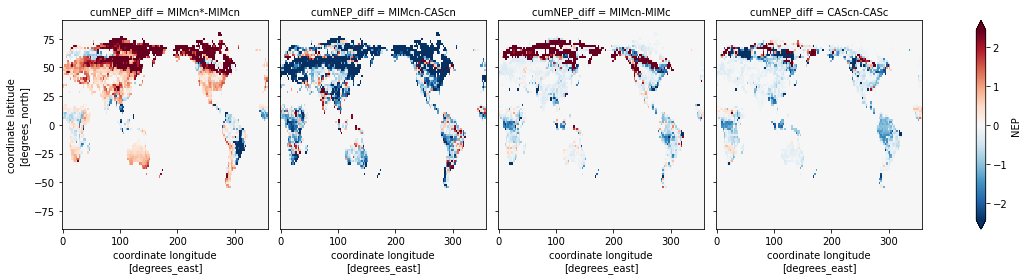

In [36]:
#Differences in NEP 
MIMcn_p_MIMcn= cumNEP.isel(sim=4)-cumNEP.isel(sim=3)
MIMcn_CAScn  = cumNEP.isel(sim=3)-cumNEP.isel(sim=1)
MIMcn_MIMc   = cumNEP.isel(sim=3)-cumNEP.isel(sim=2)
CAScn_CASc   = cumNEP.isel(sim=1)-cumNEP.isel(sim=0)

cn_c = xr.concat([MIMcn_p_MIMcn,MIMcn_CAScn,MIMcn_MIMc,CAScn_CASc], 'cumNEP_diff')
cn_c['cumNEP_diff'] = ['MIMcn*-MIMcn','MIMcn-CAScn','MIMcn-MIMc','CAScn-CASc']

g_simple = cn_c.plot(x="lon", y="lat", col="cumNEP_diff", robust=True,
                                   col_wrap=4,figsize=[16,4],cmap="RdBu_r")


**Figure y** N effects on cumulative NEP (1901-2014) 
- MIMICS with less net land uptake than CASA (left) 
- Biggest differences in cumulative NEP in MIMICS across arctic and boreal forests (middle), 
- CASA effects of N limitation on cumulative land C uptake are weaker (right) 

Are changes  really just reflecting the degree of initial N limitation in CN models?

# Changes from initial conditions

['NEP']


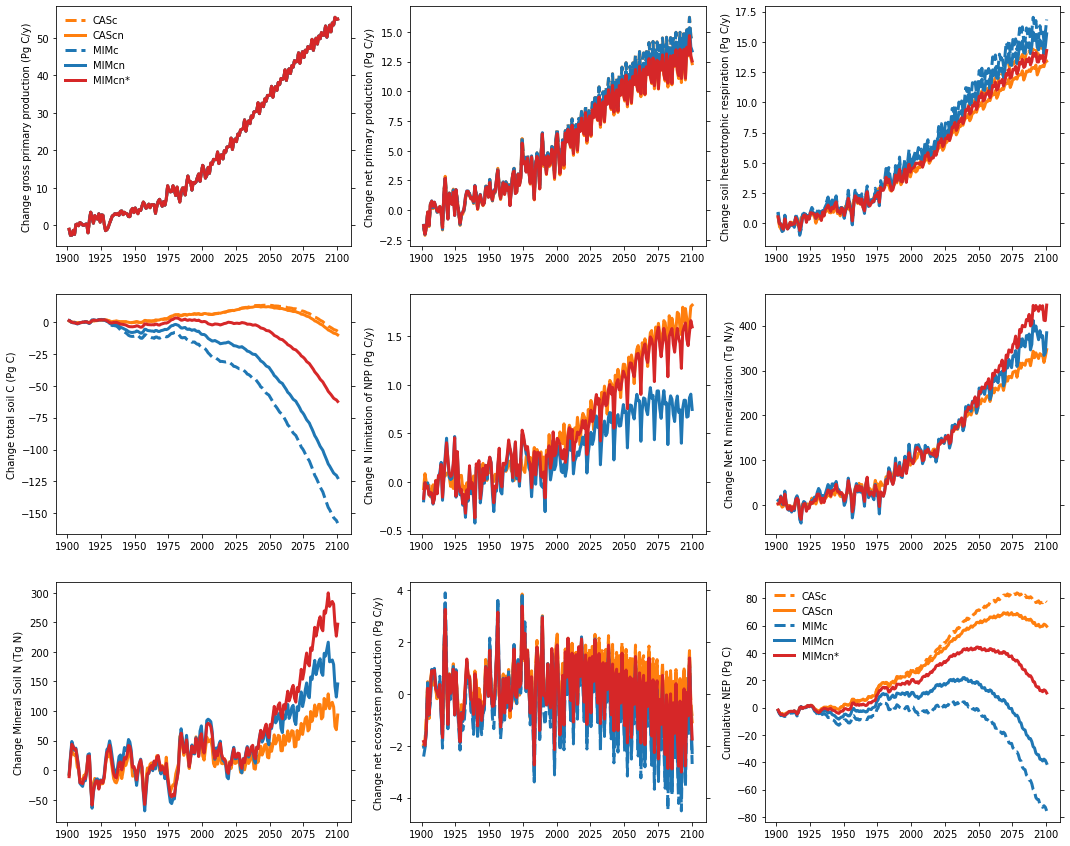

In [37]:
model = simLabs
fig = plt.figure(figsize=[18,15]);
t = 20
    
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Change '+ds[var[i]].attrs['long_name']+' '+units[i])
    for j in range(len(model)):
        temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## zero out N fluxes for C-only runs
        if j == 2 or j == 0:
            if i == 4 or i == 5 or i == 6:
                temp = temp*np.nan
                
        ax.plot(ds.time, (temp - temp.isel(time=slice(0,t)).mean()), 
                lw=3,color=color[j],linestyle=linestyle[j])        
    if i==0:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax = fig.add_subplot(3, 3, 9)
i = 7  
print([var[i]])
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
for j in range(nsim):
    ax.plot(ds.time, np.cumsum(globalSum(ds[var[i]].isel(sim=j),
                               timeC=timeC[i],conversion=conversion[i])), 
            lw=3,color=color[j],linestyle=linestyle[j])        
ax.legend(labels=model, frameon = False, fontsize='medium');

**Figure X** Changes in ecosystem C & N fluxes and pools, relative to initial conditions, over the historical period 
simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only 
configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Does this influence N limitation in regions where SOM turnover is accelerating?
- Greater IAV of C&N fluxes from MIMICS, it would be interesting to see the source & driver of this variability (temp, moisture, productivity).

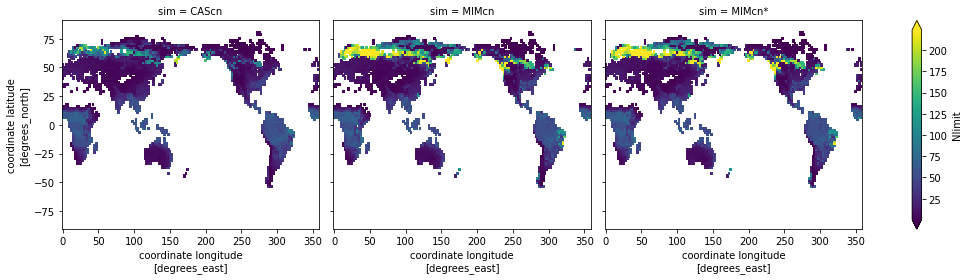

In [39]:
# Initial N limitation 
(ds['Nlimit'].isel(time=slice(0,20),sim=CNsim).mean(dim='time')*365).plot(
    x="lon", y="lat", col="sim", robust=True,figsize=[15,4],
    col_wrap=len(CNsim)) ;

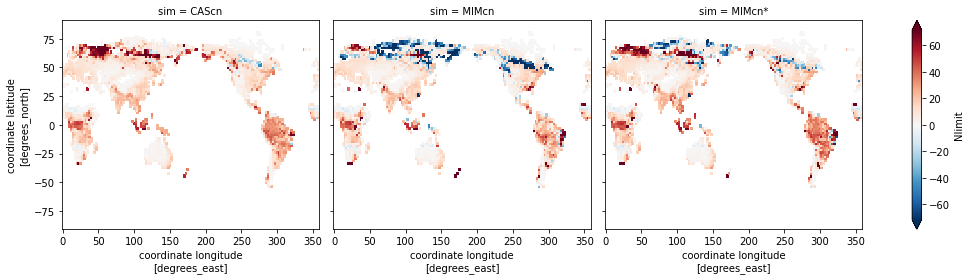

In [40]:
# look at spatial maps of changes in N limitation 2080:2100 mean - 1901:1920 mean

temp  = ((ds.isel(time=slice(-20,None)).mean(dim='time') -
          ds.isel(time=slice(0,20)).mean(dim='time')) )
plotVar = ['nNetMineralization','Nlimit','cnpp','cTOT']
 
(temp['Nlimit']*365).isel(sim=CNsim).plot(
    x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=len(CNsim)) ;

Changes in N limitation for each model look pretty different, esp at high lats
- look at zonal mean plots

KeyError: 'nNetMineralization'

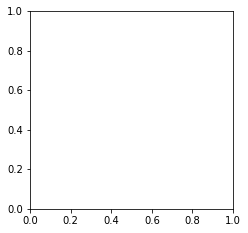

In [107]:
#dHist.mean(dim='lon').isel(deltaHist=i)
fig = plt.figure(figsize=[8,8]);
t = 20
model = ['CAScn','MIMcn','MIMcn*'] 
#color = ['tab:red','tab:blue','tab:orange']
for i in range(len(plotVar)):
    ax = fig.add_subplot(2, 2, (i+1))
    for j in CNsim:  #loop over simulations
        x = temp[plotVar[i]].mean(dim='lon').isel(sim=j)
        #convert daily to annual flux
        if i < 3: x = x*365
        ax.plot(x, temp.lat, 
                lw=3,color=color[j],linestyle=linestyle[j])
        
    ax.set_xlabel("change "+plotVar[i])
    ax.yaxis.set_ticks_position('both')
    if i==0:
        ax.legend(labels=model, frameon = False, fontsize='medium')


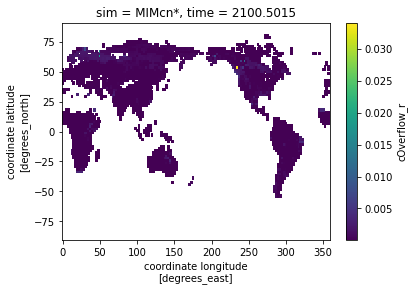

In [45]:
## Is there any overflow respiration?
((ds.cOverflow_r + ds.cOverflow_r)*365).isel(sim=4,time=-1).plot() ;

### changes in total pools

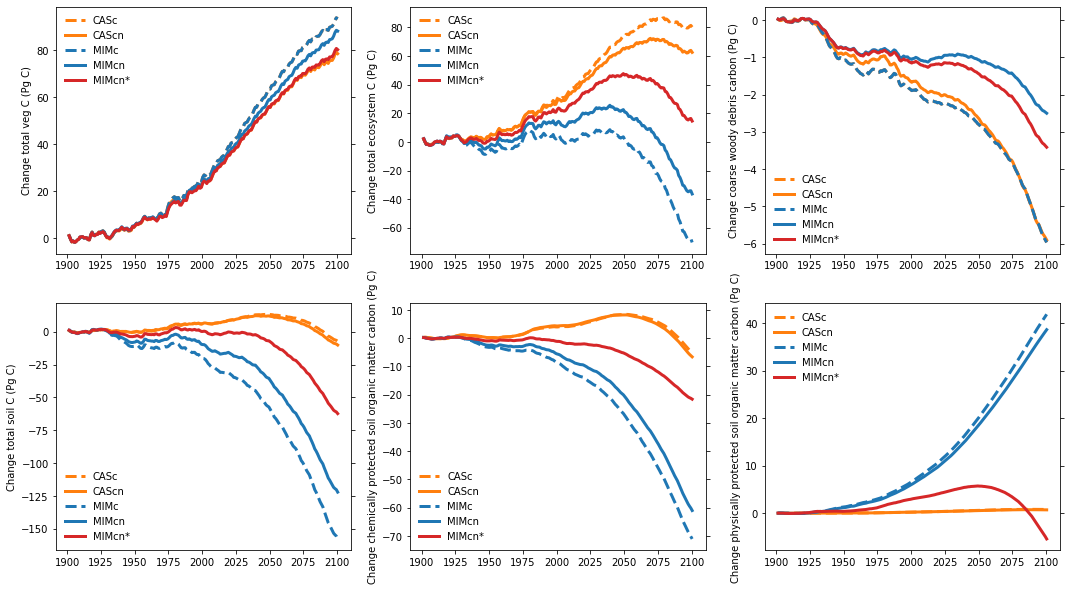

In [47]:
var = ['cVEG','cECO','clitcwd','cTOT','cSOMc','cSOMp']
timeC = [1,1,1,1,1,1]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15,1e-15]
units = ['(Pg C)','(Pg C)','(Pg C)','(Pg C)','(Pg C)','(Pg C)']
model = simLabs

fig = plt.figure(figsize=[18,10]);

# loop over variables 
for i in range(len(var)):
    ax = fig.add_subplot(2, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Change '+ds[var[i]].attrs['long_name']+' '+units[i])

    # loop over simulations
    for j in range(nsim):  
        temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## changes in passive pool for CASA-only runs
        if j < 2 :
            if i == 4:
                temp = globalSum(ds['csoilslow'].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
            if i == 5:
                temp = globalSum(ds['csoilpass'].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
                
        ax.plot(ds.time, (temp - temp.isel(time=slice(0,t)).mean()), 
            lw=3,color=color[j],linestyle=linestyle[j]) 
            
    if i==0:
        ax.legend(labels=model, frameon = False, fontsize='medium')


    plt.legend(labels=model, frameon = False, fontsize='medium');

In [77]:
# ratio of respiration:mineralization over time
var = ['cresp','nNetMineralization']
ds['HR:Min'] = (ds[var[0]]/ds[var[1]])

In [78]:
# Zonal mean of changes by end of simulation
dsZon = (ds - ds.isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')

## plot zonal mean over time

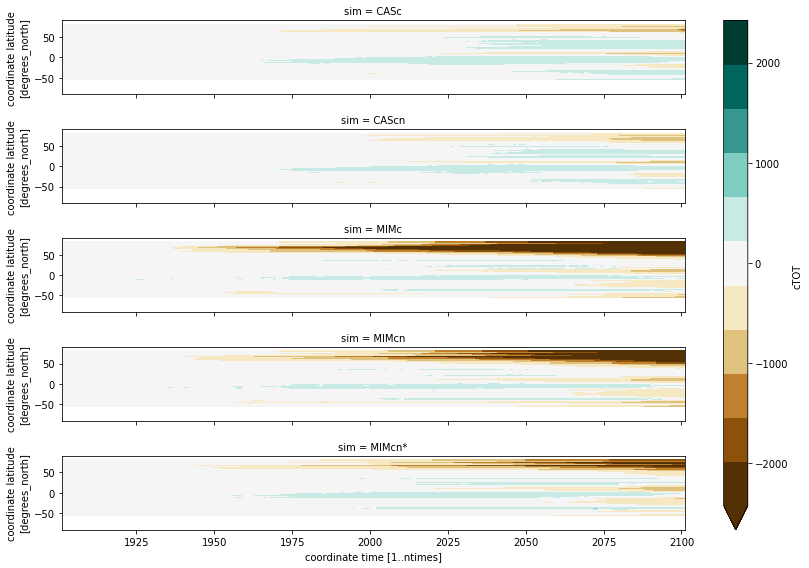

In [52]:
from matplotlib import cm

dsZon['cTOT'].plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[12,8],col_wrap=1, 
                   cmap=cm.get_cmap('BrBG', 11) ) ; 

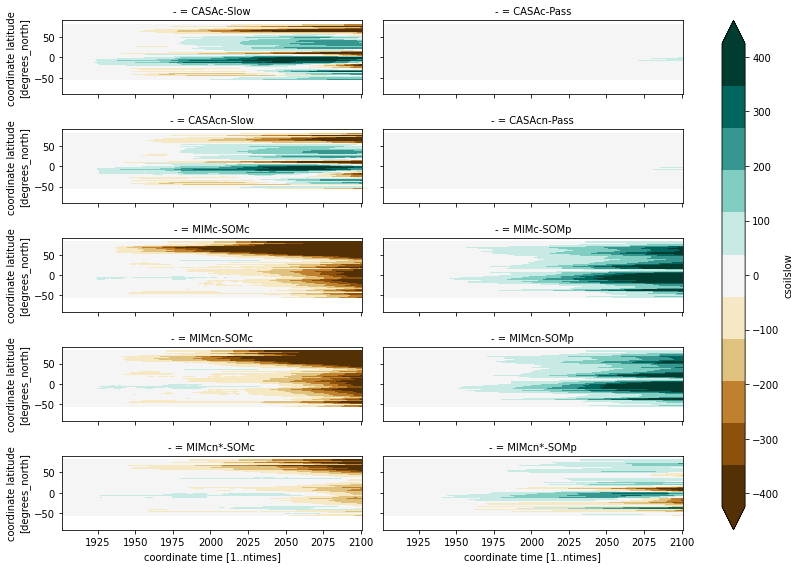

In [53]:
temp = xr.concat([dsZon.isel(sim=0)['csoilslow'], dsZon.isel(sim=0)['csoilpass'],
                 dsZon.isel(sim=1)['csoilslow'], dsZon.isel(sim=1)['csoilpass'],
                 dsZon.isel(sim=2)['cSOMc'], dsZon.isel(sim=2)['cSOMp'],
                 dsZon.isel(sim=3)['cSOMc'], dsZon.isel(sim=3)['cSOMp'],
                 dsZon.isel(sim=4)['cSOMc'], dsZon.isel(sim=4)['cSOMp']],
                 '-')
temp['-'] = ['CASAc-Slow' ,'CASAc-Pass','CASAcn-Slow','CASAcn-Pass',
                 'MIMc-SOMc'  ,'MIMc-SOMp' ,'MIMcn-SOMc' ,'MIMcn-SOMp',
                 'MIMcn*-SOMc','MIMcn*-SOMp'
                ]                 
temp.plot(
    x="time", y="lat", col="-", robust=True,figsize=[12,8],col_wrap=2,
    cmap=cm.get_cmap('BrBG', 11) ) ; 

### Plot maps of where fluxes are changing

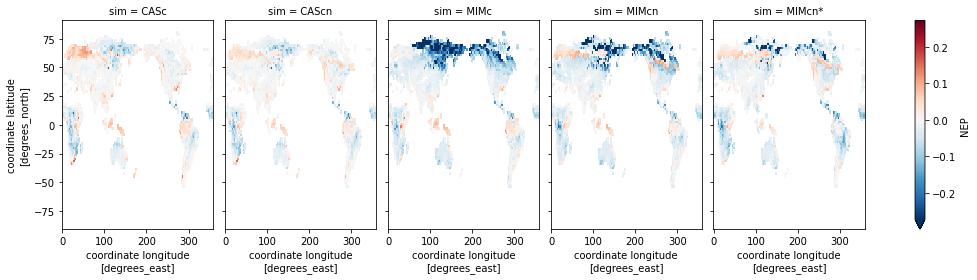

In [66]:
var='NEP'
(ds[var].isel(time=slice(-20,None)).mean(dim='time')-
 ds[var].isel(time=slice(  0,20  )).mean(dim='time')).plot(
    x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim);

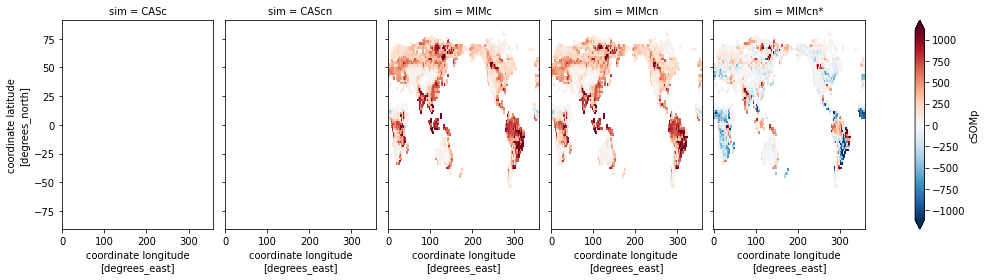

In [67]:
var = ['cresp','tsoilC','nNetMineralization','cSOMp','cTOT','fW']
tempMIM = (ds[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           ds[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempMIM.plot(x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim) ;

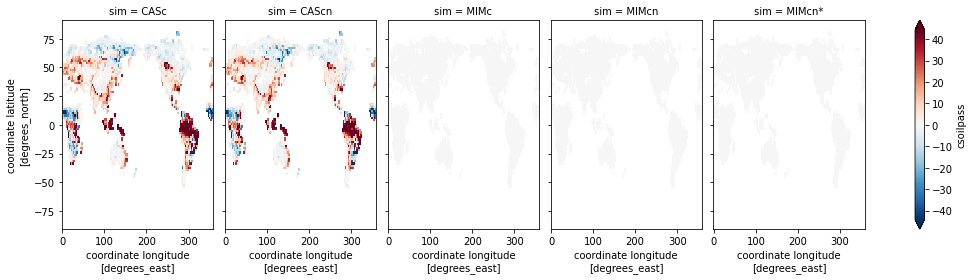

In [68]:
var = ['cresp','tsoilC','nNetMineralization','csoilpass','cTOT','fW']
tempCAS = (ds[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           ds[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempCAS.plot(x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim) ;

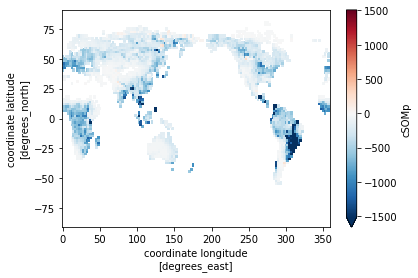

In [69]:
(tempMIM.isel(sim=4) - tempMIM.isel(sim=3)).plot(robust=True);
# not sure what a meaningful way to look at these changes may be?

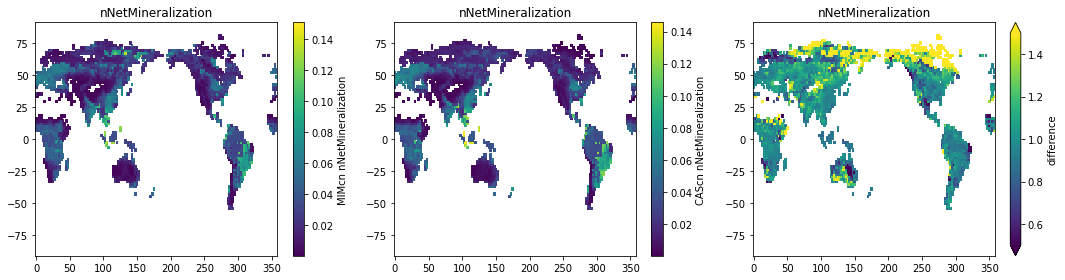

In [76]:

ncols = 3
nrows = 1
#  lists of variables, titles & labels
plotVars = ['nNetMineralization']
plotTitle = ['nNetMineralization']
plotLable = ['nNetMineralization']

# create the plots
fig = plt.figure(figsize=(15,4))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
j=0            
for ax in axes:
    if i == 0:
        ds[plotVars[j]].isel(time=-1,sim=3).plot(ax=ax, cbar_kwargs={'label': 'MIMcn '+plotLable[j]})
    if i == 1:
        ds[plotVars[j]].isel(time=-1,sim=1).plot(ax=ax,  cbar_kwargs={'label': 'CAScn '+plotLable[j]})
    if i == 2:
        (ds[plotVars[j]].isel(time=-1,sim=3)/  \
         ds[plotVars[j]]).isel(time=-1,sim=1).plot(
            ax=ax, vmax=1.5,vmin=0.5, cbar_kwargs={'label': 'difference'})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[j])
    i = i+1

plt.tight_layout()

#MIMcnANN['HR:Min'].isel(time=0).plot(robust=True);

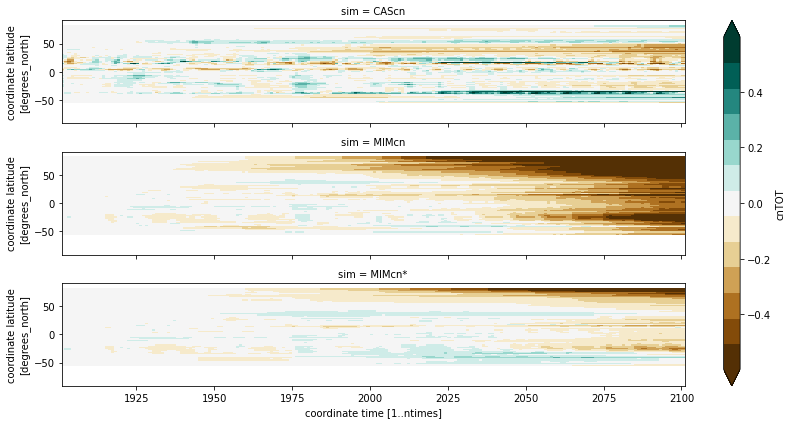

In [97]:
#changes in mineralization over time in both models
var2 = ['cnpp','cresp','NEP','cTOT','nNetMineralization','HR:Min','cnTOT']

dsZon[var2[6]].isel(sim=CNsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[12,6],col_wrap=1, 
                   cmap=cm.get_cmap('BrBG', 13) ) ;  


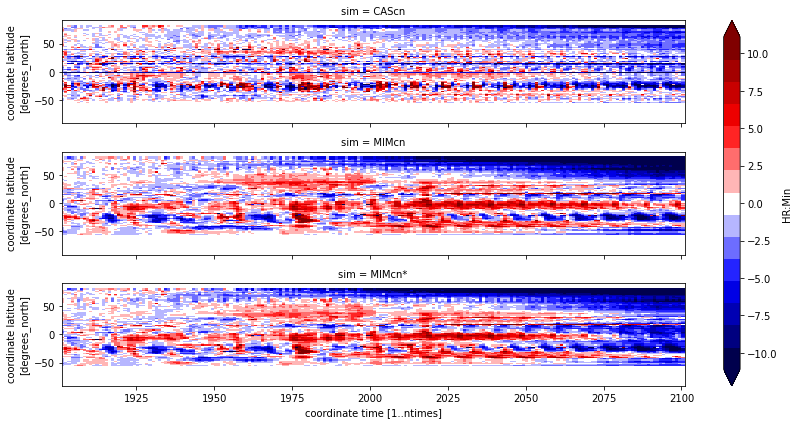

In [95]:
# Basically show the C:N of microbial spilling
dsZon['HR:Min'].isel(sim=CNsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[12,6],col_wrap=1, 
                   cmap=cm.get_cmap('seismic', 15) ) ; 

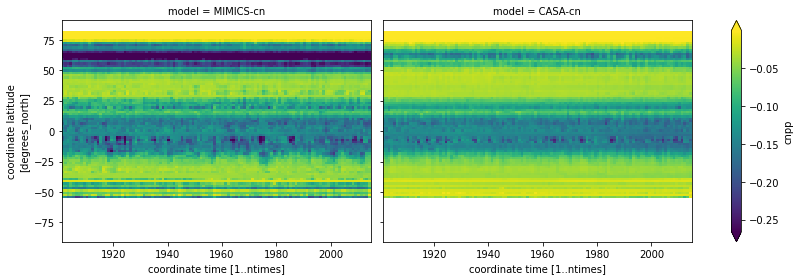

In [37]:
#changes, relative to the C-only model
var2 = ['cnpp','cresp','NEP','cTOT']
ds2 = ds[var2].copy('deep')

dMIMcn_P = (ds2.isel(sim=4)-ds2.isel(sim=(4-1))).mean(dim='lon')
dMIMcn = (ds2.isel(sim=3)-ds2.isel(sim=(3-1))).mean(dim='lon')
dCAScn = (ds2.isel(sim=1)-ds2.isel(sim=(1-1))).mean(dim='lon') 

model = xr.DataArray(['MIMICS-cn*''MIMICS-cn','CASA-cn'], dims='model', name='model') # or can use np.arange
t = xr.concat([dMIMcn_P, dMIMcn,dCAScn],dim=model)

#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t[var2[0]].plot(x='time', y='lat',col='model',col_wrap=3, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);



**Figure X.** Zonal mean changes in rates simulated by MIMICS-cn 

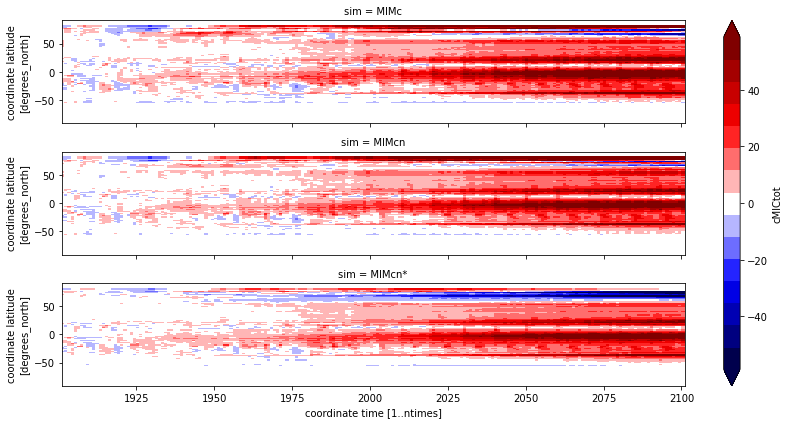

In [105]:
# Mimics specifics rsults
# var = ['specRESP','cMICtot','MICrK','cnMIC']
dsZon['cMICtot'].isel(sim=MIMsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[12,6],col_wrap=1, 
                   cmap=cm.get_cmap('seismic', 15) ) ; 

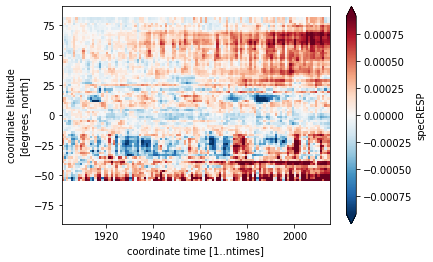

In [38]:
# look a some MIM specific results
var = ['specRESP','cMICtot','MICrK','cnMIC']
(MIMcnANN[var[0]]-MIMcnANN[var[0]].isel(time=slice(0,10)).mean(dim='time')).mean(dim='lon').plot(x='time',y='lat',robust=True);
#MIMcnANN

### Look at environmental controls over soil C:N in MIMICS

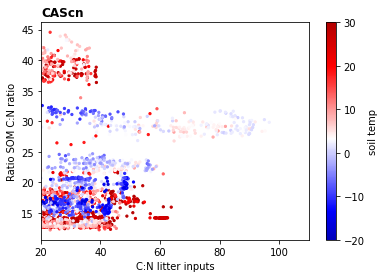

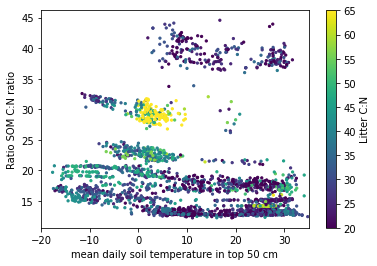

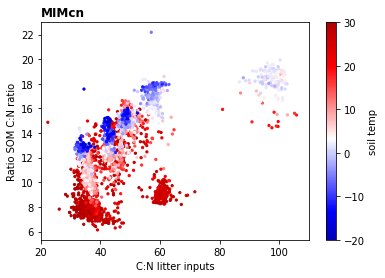

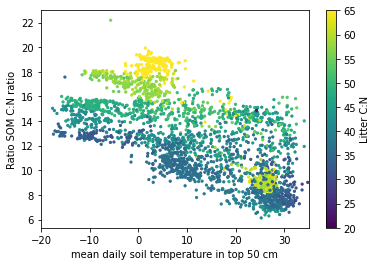

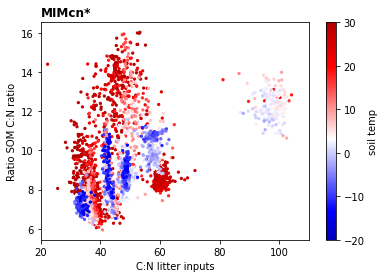

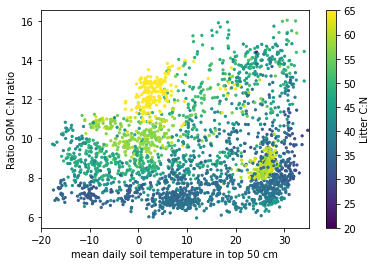

In [106]:
for i in [1,3,4]:
    ds_1 = ds.isel(time=0, sim=i)
    if i == 1:
        ds_1['cnLIT'] = (ds_1.cLitInptMet + ds_1.cLitInptStruc) / \
                         (ds_1.nLitInptMet + ds_1.nLitInptStruc)
    else:
        ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / \
                         (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
    ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

    color_by = ds_1.tsoilC
    label = 'soil temp'  # Need to rename if 'color_by' is changed

    fig, ax = plt.subplots()
    s = ax.scatter(ds_1['cnLIT'], ds_1['cnTOT'],
                   c=color_by,
                   s=5,
                   marker='o',                   # Plot circles
                  # alpha = 0.2,
                   cmap = utils.truncate_colormap(
                       cmapIn='seismic', minval=.15, maxval=.9),#coolwarm
                   vmin = -20,            # Min value
                   vmax = 30)             # Max value

    # Mappable 'maps' the values of s to an array of RGB colors 
    #  defined by a color palette
    cbar = plt.colorbar(mappable = s, ax = ax)   
    cbar.set_label(label)
    plt.xlabel(ds_1['cnLIT'].attrs['long_name'])
    plt.ylabel(ds_1['cnTOT'].attrs['long_name'])
    plt.title(model[i],loc='left', fontsize='large', 
              fontweight='bold')
    ax.set_xlim(20, 110)
    plt.show();

    color_by = ds_1['cnLIT'] 
    label = 'Litter C:N'     
    #fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), constrained_layout=True)
    fig, ax = plt.subplots()
    s = ax.scatter(ds_1.tsoilC, ds_1['cnTOT'],
                   c=color_by,
                   s=5,
                   marker='o',          # Plot circles
                   #alpha = 0.2,
                   #cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
                   vmin = 20,           # Min value
                   vmax = 65)           # Max value

    # Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
    cbar = plt.colorbar(mappable = s, ax = ax)   
    cbar.set_label(label)
    plt.xlabel(ds_1['tsoilC'].attrs['long_name'])
    plt.ylabel(ds_1['cnTOT'].attrs['long_name'])
    ax.set_xlim(-20, 35)
    plt.show();


**Figure 3** Temperature and litter stoichiometry interact to determine the soil C:N ratios that are simulated by MIMICS-CN. Points represent the gridcell mean annual stoichiometry of litterfall C:N fluxes that are simulated by the CASA-CNP vegetation model and resulting soil C:N ratios that are simulated by MIMICS.  The color of each point indicates mean annual soil temperature simulated by over the spin-up period (1901-1920). 


### Annual cycle of fluxes, not enabled for SSP simulations yet
This can be done for grid cells, or zonally

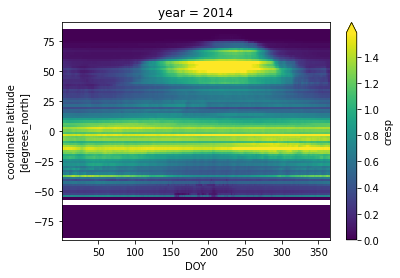

In [40]:
var = ['cMICtot','nMineral','cresp','nNetMineralization','MICrK','cnMIC','cnpp']
v = 2
ds.isel(year=-1)[var[v]].mean(dim='lon').plot(x='DOY', robust=True);

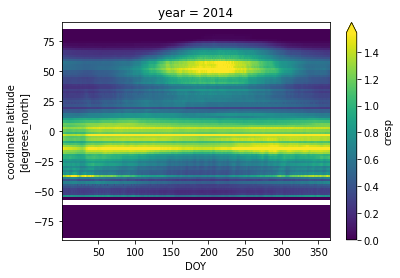

In [41]:
CAScn.isel(year=-1)[var[v]].mean(dim='lon').plot(x='DOY', robust=True);

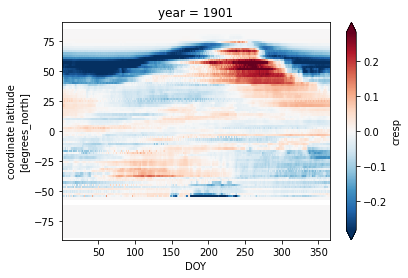

In [42]:
# Differences betweeen models (MIMICS-CASA)
v = 2
(MIMcn.isel(year=0)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(x='DOY', robust=True);

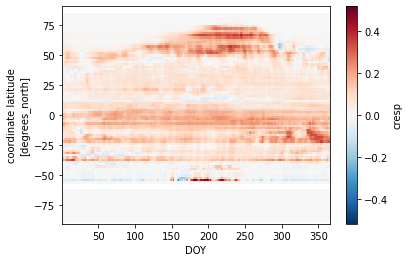

In [43]:
v = 2
(MIMcn.isel(year=1)[var[v]] - MIMcn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2);

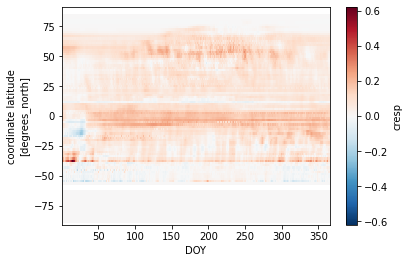

In [44]:
(CAScn.isel(year=1)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2) ;

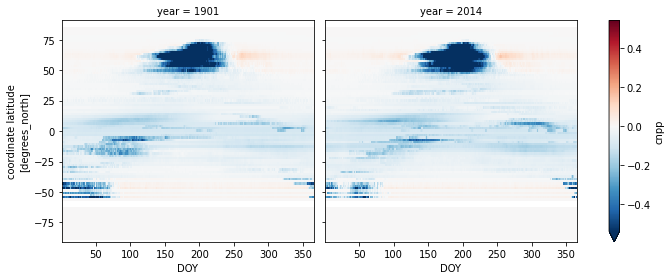

In [45]:
# how N limited are arctic systems at end of simulation in each model?
v = 6
simple = (MIMcn[var[v]]- MIMc[var[v]]).mean(dim='lon').plot(x='DOY', y='lat',col='year',col_wrap=2, figsize=[10,4],robust=True);#vmax=5e-3,vmin=-5e-3);

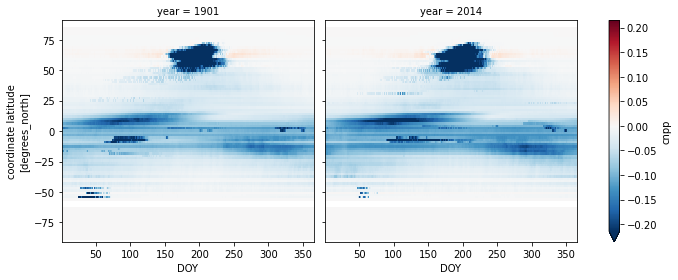

In [46]:
simple = (CAScn[var[v]]- CASc[var[v]]).mean(dim='lon').plot(x='DOY', y='lat',col='year',col_wrap=2, figsize=[10,4],robust=True);#vmax=5e-3,vmin=-5e-3);

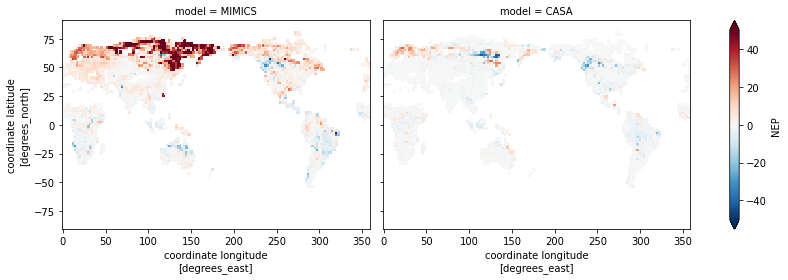

In [47]:
var = 'NEP'
Neff_mim = MIMcnANN[var]-MIMcANN[var]
Neff_cas = CAScnANN[var]-CAScANN[var]
Neff_mim = Neff_mim.isel(time=slice(-20,None)).mean(dim='time') - Neff_mim.isel(time=slice(0,20)).mean(dim='time')
Neff_cas = Neff_cas.isel(time=slice(-20,None)).mean(dim='time') - Neff_cas.isel(time=slice(0,20)).mean(dim='time')
model = xr.DataArray(['MIMICS','CASA'], dims='model', name='model') # or can use np.arange
t = xr.concat([Neff_mim,Neff_cas],dim=model)
t = t*365 #convert from gC/m2/d to gC/m2/y
#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t.plot(x='lon', y='lat',col='model',col_wrap=2, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);


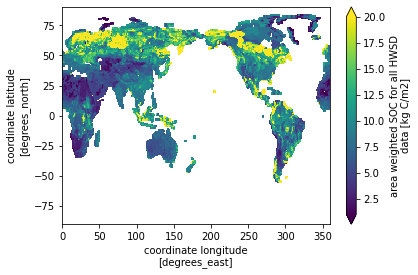

In [49]:
dsOBS['HWSD_SOCall'].plot(vmax=20,vmin=1);